In [5]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
print("TensorFlow version:", tf.__version__)

# Use GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        pass

TensorFlow version: 2.20.0


In [6]:
TRAIN_DIR =r"C:\Users\prath\OneDrive\Desktop\train_images"
print("Using training directory:", TRAIN_DIR)

Using training directory: C:\Users\prath\OneDrive\Desktop\train_images


In [8]:
from pathlib import Path

# If TRAIN_DIR is a string, convert it to Path
TRAIN_DIR = Path(TRAIN_DIR)

print("TRAIN_DIR =", TRAIN_DIR)
print("Exists:", TRAIN_DIR.exists())


TRAIN_DIR = C:\Users\prath\OneDrive\Desktop\train_images
Exists: True


In [11]:
# Build DataFrame of image path and label
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
rows = []
for cls_dir in sorted([d for d in TRAIN_DIR.iterdir() if d.is_dir()]):
    label = cls_dir.name
    for img_path in cls_dir.iterdir():
        if img_path.suffix.lower() in image_extensions:
            rows.append({"filepath": str(img_path), "label": label})
df = pd.DataFrame(rows)
print("Total images found:", len(df))
df.head()


Total images found: 10406


,filepath,label
0,C:\Users\prath\OneDrive\Desktop\train_images\b...,bacterial_leaf_blight
1,C:\Users\prath\OneDrive\Desktop\train_images\b...,bacterial_leaf_blight
2,C:\Users\prath\OneDrive\Desktop\train_images\b...,bacterial_leaf_blight
3,C:\Users\prath\OneDrive\Desktop\train_images\b...,bacterial_leaf_blight
4,C:\Users\prath\OneDrive\Desktop\train_images\b...,bacterial_leaf_blight


In [15]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = df['label'].nunique()

# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.05,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
print("Class indices:", class_indices)


Found 8324 validated image filenames belonging to 10 classes.
Found 2082 validated image filenames belonging to 10 classes.
Class indices: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


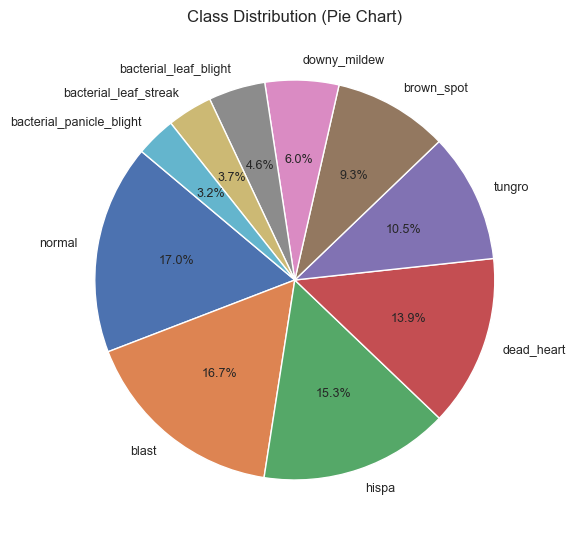

Number of classes: 10

Images per class:
label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        478
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64


In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Use your dataframe here (choose the one that exists)
# df = train_df   # or val_df or df
# If you have val_df & train_df combined, use that one

# Count images per class
class_counts = df['label'].value_counts()

# --- PIE CHART ---
plt.figure(figsize=(6,6))
plt.pie(class_counts.values,
        labels=class_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9})

plt.title("Class Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

# Print summary in text
print("Number of classes:", len(class_counts))
print("\nImages per class:")
print(class_counts)


Total images: 10406
Total classes: 10
Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


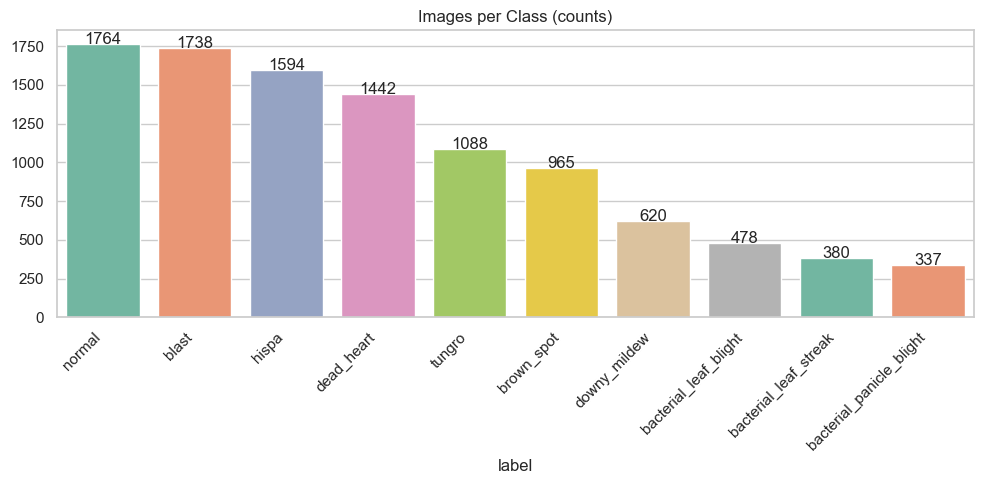

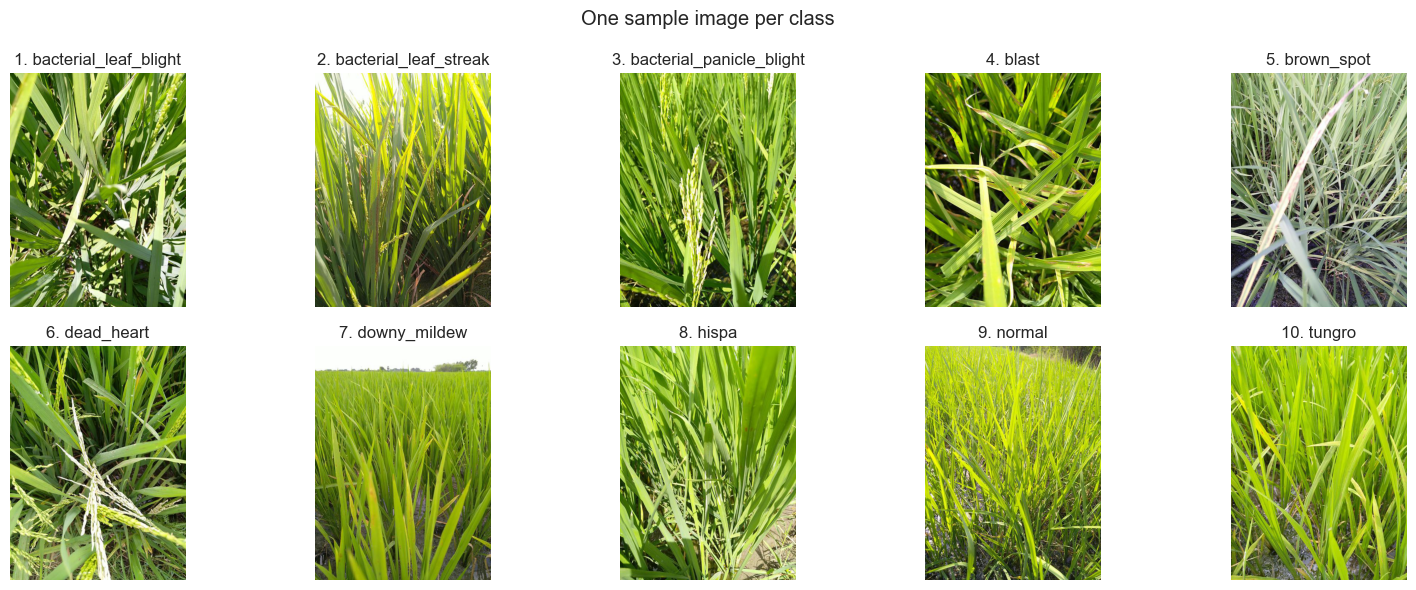

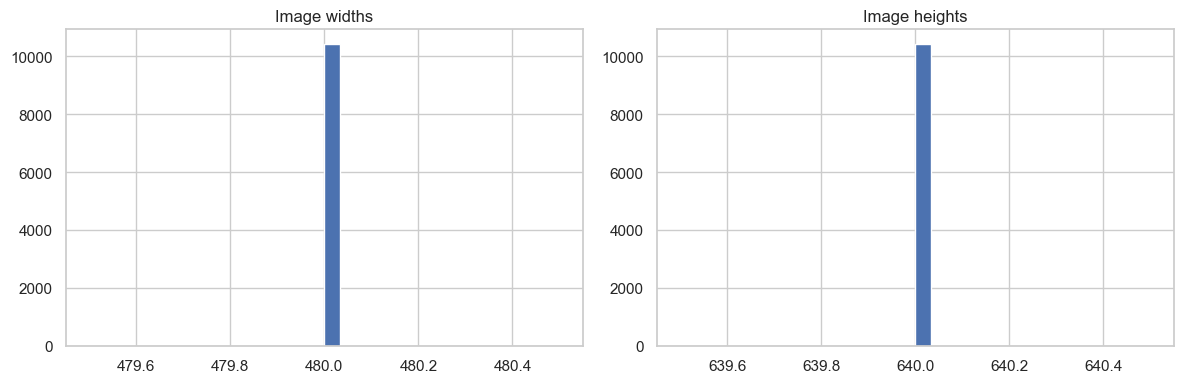

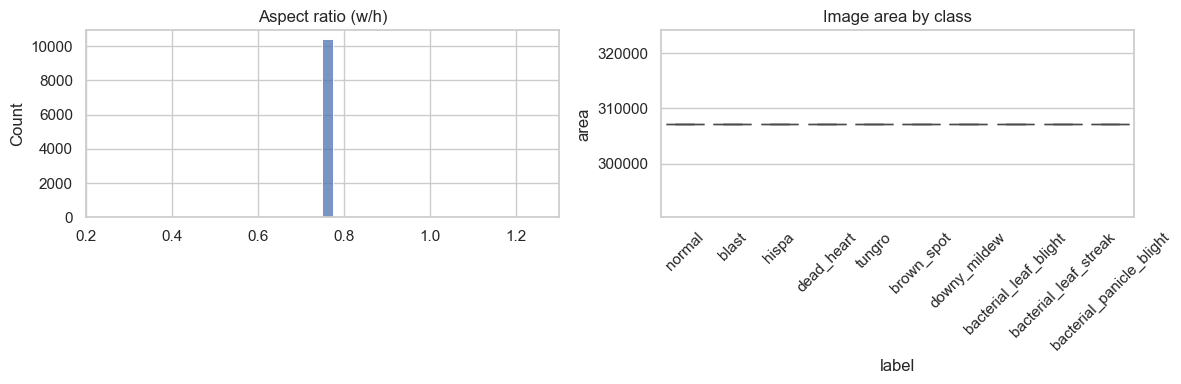

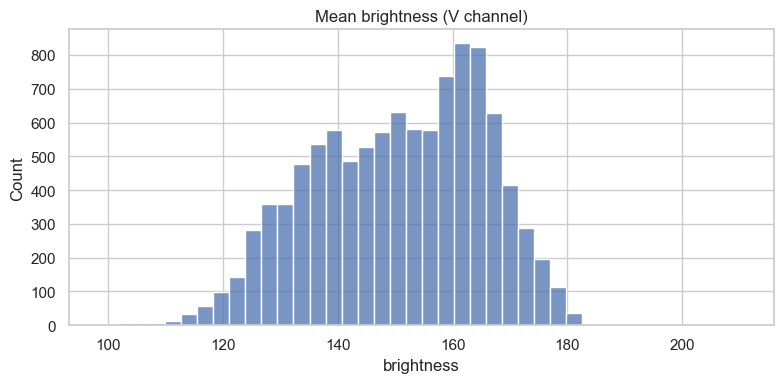

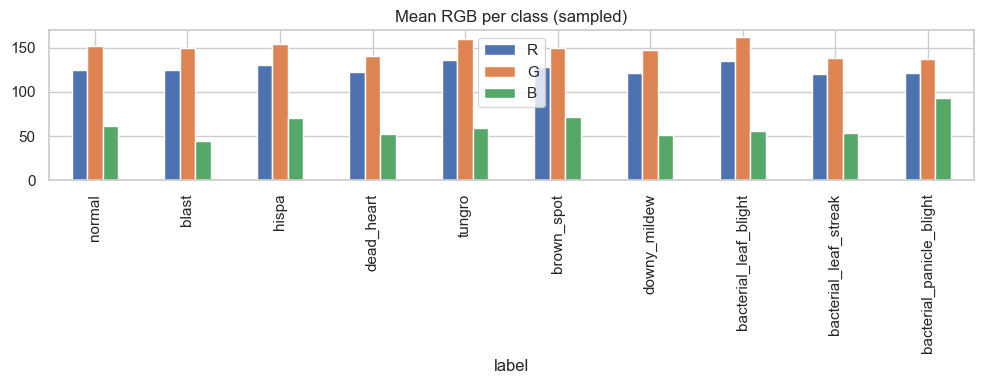

EDA visuals saved to viz_outputs


In [82]:
# EDA: dataset overview — paste right after df is created
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd
from PIL import Image
import cv2
from pathlib import Path
sns.set(style="whitegrid")

OUTDIR = Path("viz_outputs")
OUTDIR.mkdir(exist_ok=True)

# Basic counts
print("Total images:", len(df))
print("Total classes:", df['label'].nunique())
print("Classes:", sorted(df['label'].unique()))

# 1. Bar chart (counts)
plt.figure(figsize=(10,5))
counts = df['label'].value_counts()
ax = sns.barplot(x=counts.index, y=counts.values, palette="Set2")
plt.xticks(rotation=45, ha='right')
plt.title("Images per Class (counts)")
for i,p in enumerate(ax.patches):
    ax.annotate(int(p.get_height()), (i, p.get_height()+0.5), ha='center')
plt.tight_layout(); plt.savefig(OUTDIR/"bar_counts.png", dpi=200); plt.show()

# 4. One sample per class grid
classes = sorted(df['label'].unique())
cols = 5
rows = int(np.ceil(len(classes)/cols))
plt.figure(figsize=(16, rows*3))
for i,cls in enumerate(classes):
    sample = df[df['label']==cls].sample(1, random_state=42).iloc[0]
    img = Image.open(sample['filepath']).convert('RGB')
    plt.subplot(rows, cols, i+1)
    plt.imshow(img); plt.axis('off'); plt.title(f"{i+1}. {cls}")
plt.suptitle("One sample image per class"); plt.tight_layout(); plt.savefig(OUTDIR/"one_sample_per_class.png", dpi=200); plt.show()

# 5. Image size distributions
def get_size(p): 
    try:
        with Image.open(p) as im:
            return im.size  # (w,h)
    except:
        return (np.nan,np.nan)
sizes = df['filepath'].apply(get_size)
df['width'] = sizes.apply(lambda s: s[0]); df['height'] = sizes.apply(lambda s: s[1]); df['area']=df['width']*df['height']
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.hist(df['width'].dropna(), bins=30); plt.title("Image widths")
plt.subplot(1,2,2); plt.hist(df['height'].dropna(), bins=30); plt.title("Image heights")
plt.tight_layout(); plt.savefig(OUTDIR/"image_sizes.png", dpi=200); plt.show()

# 6. Aspect ratio & area boxplot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.histplot(df['width']/df['height'], bins=40); plt.title("Aspect ratio (w/h)")
plt.subplot(1,2,2); sns.boxplot(x='label', y='area', data=df, order=counts.index); plt.xticks(rotation=45); plt.title("Image area by class")
plt.tight_layout(); plt.savefig(OUTDIR/"aspect_area.png", dpi=200); plt.show()

# 7. Brightness distribution
def mean_brightness(p):
    try:
        im = np.array(Image.open(p).convert('RGB').resize((64,64)))
        hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        return hsv[:,:,2].mean()
    except:
        return np.nan
df['brightness'] = df['filepath'].apply(mean_brightness)
plt.figure(figsize=(8,4)); sns.histplot(df['brightness'].dropna(), bins=40); plt.title("Mean brightness (V channel)")
plt.tight_layout(); plt.savefig(OUTDIR/"brightness.png", dpi=200); plt.show()

# 8. Mean RGB per class (sample)
sampled = df.groupby('label').apply(lambda g: g['filepath'].sample(min(10,len(g)), random_state=1).tolist())
rgb_means = {}
for cls, paths in sampled.items():
    vals=[]
    for p in paths:
        try:
            im = np.array(Image.open(p).convert('RGB').resize((32,32))).astype(np.float32)
            vals.append(im.mean(axis=(0,1)))
        except:
            pass
    if vals:
        rgb_means[cls] = np.mean(vals, axis=0)
rgb_df = pd.DataFrame.from_dict(rgb_means, orient='index', columns=['R','G','B']).loc[counts.index]
rgb_df.plot(kind='bar', figsize=(10,4)); plt.title("Mean RGB per class (sampled)"); plt.tight_layout(); plt.savefig(OUTDIR/"rgb_means.png", dpi=200); plt.show()

# Save class counts CSV
counts.to_csv(OUTDIR/"class_counts.csv", header=['count'])
print("EDA visuals saved to", OUTDIR)


In [75]:
# Create train/val split dataframe
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print("Train size:", len(train_df), "Val size:", len(val_df))


Train size: 8324 Val size: 2082


In [83]:
# Save mapping for later prediction/loading
import json
class_indices = train_generator.class_indices
with open("class_indices.json","w") as f:
    json.dump(class_indices, f)
print("Saved class_indices.json")


Saved class_indices.json


In [21]:
# === ResNet50 transfer-learning model cell ===
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# SETTINGS
# IMG_SIZE should be a tuple like (224, 224)
# BATCH_SIZE and NUM_CLASSES defined previously
print("Using IMG_SIZE:", IMG_SIZE, "BATCH_SIZE:", BATCH_SIZE, "NUM_CLASSES:", NUM_CLASSES)

# Use ResNet50 as base model with ImageNet weights
base_model = applications.ResNet50(
    include_top=False,
    weights='imagenet',           # use 'imagenet' for pretrained weights
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze base for initial training

Using IMG_SIZE: (224, 224) BATCH_SIZE: 16 NUM_CLASSES: 10


In [22]:
# Build top layers
inputs = layers.Input(shape=IMG_SIZE + (3,))
# Optional: use the model's preprocessing function if you feed raw pixel [0,255] images
# from tensorflow.keras.applications.resnet50 import preprocess_input
# x = layers.Lambda(preprocess_input)(inputs)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="gap")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs, name="ResNet50_transfer")
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "ResNet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,652,170 (94.04 MB)

 Trainable params: 1,059,338 (4.04 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [23]:
# CALLBACKS (reuse/adjust as needed)
checkpoint_path = "best_resnet50.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]


In [24]:
# INITIAL TRAINING: train top layers only
EPOCHS_TOP = 12
history_top = model.fit(
    train_generator,
    epochs=EPOCHS_TOP,
    validation_data=val_generator,
    callbacks=callbacks
)

C:\Users\prath\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2334 - loss: 2.5508   
Epoch 1: val_accuracy improved from None to 0.33381, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 782s 1s/step - accuracy: 0.2660 - loss: 2.3009 - val_accuracy: 0.3338 - val_loss: 1.9324 - learning_rate: 0.0010
Epoch 2/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3013 - loss: 2.0506  
Epoch 2: val_accuracy improved from 0.33381 to 0.39962, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.3080 - loss: 2.0129 - val_accuracy: 0.3996 - val_loss: 1.8055 - learning_rate: 0.0010
Epoch 3/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3383 - loss: 1.9214  
Epoch 3: val_accuracy did not improve from 0.39962
521/521 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.3342 - loss: 1.9165 - val_accuracy: 0.3890 - val_loss: 1.8659 - learning_rate: 0.0010
Epoch 4/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3618 - loss: 1.8632  
Epoch 4: val_accuracy did not improve from 0.39962
521/521 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.3567 - loss: 1.8622 - val_accuracy: 0.3770 - val_loss: 1.8293 - learning_rate: 0.0010
Epoch 5/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3552 - loss: 1.8223  
Epoch 5: val_accuracy improved from 0.39962 to 0.40250, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.3584 - loss: 1.8368 - val_accuracy: 0.4025 - val_loss: 1.7831 - learning_rate: 0.0010
Epoch 6/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3672 - loss: 1.8342  
Epoch 6: val_accuracy improved from 0.40250 to 0.40634, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.3685 - loss: 1.8136 - val_accuracy: 0.4063 - val_loss: 1.7945 - learning_rate: 0.0010
Epoch 7/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3696 - loss: 1.8032  
Epoch 7: val_accuracy improved from 0.40634 to 0.44332, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.3840 - loss: 1.7781 - val_accuracy: 0.4433 - val_loss: 1.6589 - learning_rate: 0.0010
Epoch 8/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3819 - loss: 1.7753  
Epoch 8: val_accuracy did not improve from 0.44332
521/521 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.3885 - loss: 1.7571 - val_accuracy: 0.4289 - val_loss: 1.7359 - learning_rate: 0.0010
Epoch 9/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3934 - loss: 1.7717  
Epoch 9: val_accuracy improved from 0.44332 to 0.44813, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.3879 - loss: 1.7653 - val_accuracy: 0.4481 - val_loss: 1.6661 - learning_rate: 0.0010
Epoch 10/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3812 - loss: 1.7459  
Epoch 10: val_accuracy did not improve from 0.44813
521/521 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.3927 - loss: 1.7390 - val_accuracy: 0.4352 - val_loss: 1.7077 - learning_rate: 0.0010
Epoch 11/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3958 - loss: 1.7262  
Epoch 11: val_accuracy improved from 0.44813 to 0.46638, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.3961 - loss: 1.7216 - val_accuracy: 0.4664 - val_loss: 1.6373 - learning_rate: 0.0010
Epoch 12/12
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4025 - loss: 1.7067  
Epoch 12: val_accuracy did not improve from 0.46638
521/521 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.3997 - loss: 1.7185 - val_accuracy: 0.4376 - val_loss: 1.7184 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 11.


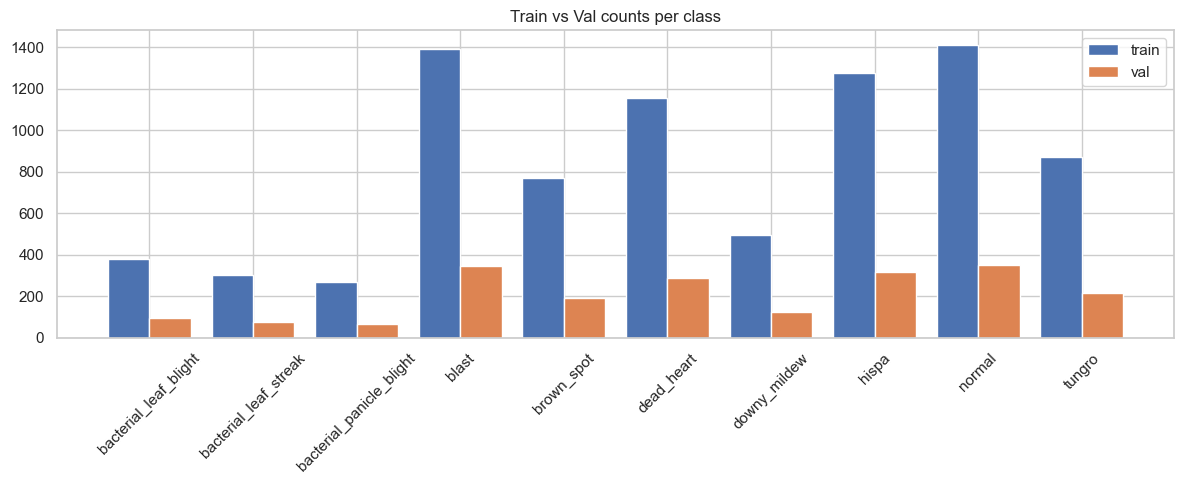

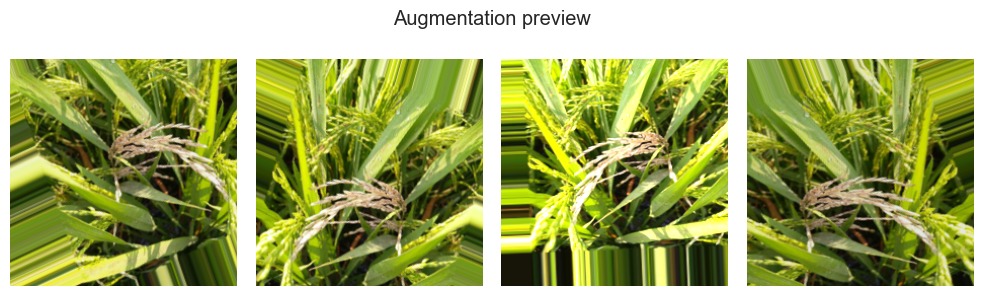

In [84]:
# Augmentation preview & train/val class distribution
OUTDIR.mkdir(exist_ok=True, parents=True)

# Train/val counts side-by-side bar
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()
classes_union = sorted(set(train_counts.index).union(set(val_counts.index)))
tr = [train_counts.get(c,0) for c in classes_union]
va = [val_counts.get(c,0) for c in classes_union]
ind = np.arange(len(classes_union))
plt.figure(figsize=(12,5))
plt.bar(ind-0.2, tr, width=0.4, label='train'); plt.bar(ind+0.2, va, width=0.4, label='val')
plt.xticks(ind, classes_union, rotation=45); plt.legend(); plt.title("Train vs Val counts per class")
plt.tight_layout(); plt.savefig(OUTDIR/"train_val_counts.png", dpi=200); plt.show()

# Augmentation preview (4 augmented samples)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.12, height_shift_range=0.12, zoom_range=0.15, horizontal_flip=True, brightness_range=(0.7,1.3))
sample_path = train_df['filepath'].sample(1, random_state=7).iloc[0]
img = np.expand_dims(np.array(Image.open(sample_path).convert('RGB').resize(IMG_SIZE)), 0)
plt.figure(figsize=(10,3))
i=0
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(1,4,i+1); plt.imshow(batch[0].astype('uint8')); plt.axis('off')
    i+=1
    if i==4: break
plt.suptitle("Augmentation preview"); plt.tight_layout(); plt.savefig(OUTDIR/"aug_preview.png", dpi=200); plt.show()


131/131 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step


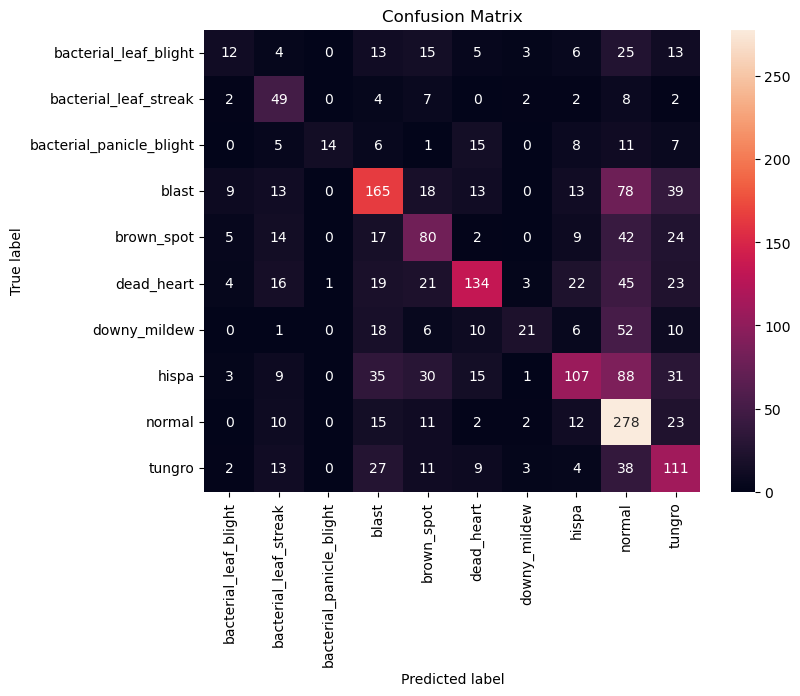

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.32      0.12      0.18        96
   bacterial_leaf_streak       0.37      0.64      0.47        76
bacterial_panicle_blight       0.93      0.21      0.34        67
                   blast       0.52      0.47      0.49       348
              brown_spot       0.40      0.41      0.41       193
              dead_heart       0.65      0.47      0.54       288
            downy_mildew       0.60      0.17      0.26       124
                   hispa       0.57      0.34      0.42       319
                  normal       0.42      0.79      0.55       353
                  tungro       0.39      0.51      0.44       218

                accuracy                           0.47      2082
               macro avg       0.52      0.41      0.41      2082
            weighted avg       0.51      0.47      0.45      2082



In [27]:
# Load best model (if saved)
model.load_weights(checkpoint_path)

# Predict on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))


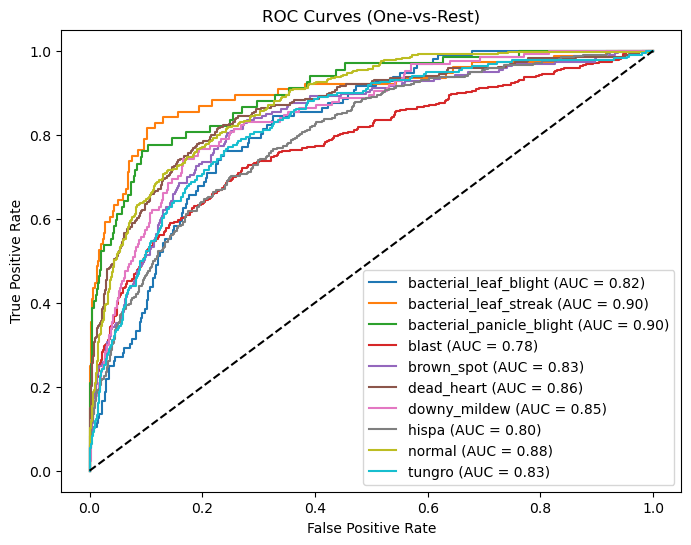

In [28]:
# ROC per-class (requires binarized labels)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(labels)))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:0.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

In [35]:
base_model.trainable = True

# 2. Try to locate a good layer to start fine-tuning
fine_tune_at = None

for i, layer in enumerate(base_model.layers):
    if layer.name == "conv4_block1_out":  # good fine-tuning start layer
        fine_tune_at = i
        break

# 3. If the layer was not found (different architecture wrapper), fallback
if fine_tune_at is None:
    fine_tune_at = len(base_model.layers) - 30   # last 30 layers

print("Fine-tuning starting at layer index:", fine_tune_at)

# 4. Freeze layers *before* fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 5. Unfreeze remaining top layers
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# 6. Re-compile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 7. Run fine-tuning
EPOCHS_FINE = 2

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE,
    callbacks=callbacks
)


Fine-tuning starting at layer index: 92
Epoch 1/2
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3182 - loss: 1.9588   
Epoch 1: val_accuracy did not improve from 0.46638
521/521 ━━━━━━━━━━━━━━━━━━━━ 1355s 3s/step - accuracy: 0.3340 - loss: 1.9192 - val_accuracy: 0.4150 - val_loss: 1.7082 - learning_rate: 1.0000e-05
Epoch 2/2
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3795 - loss: 1.8132   
Epoch 2: val_accuracy improved from 0.46638 to 0.47454, saving model to best_resnet50.h5


521/521 ━━━━━━━━━━━━━━━━━━━━ 1296s 2s/step - accuracy: 0.3789 - loss: 1.8013 - val_accuracy: 0.4745 - val_loss: 1.5535 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 2.


In [38]:
model = tf.keras.models.load_model("paddy_resnet50_model.keras", compile=False)


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [70]:
# Combine history_top and history_fine into a single history object
combined_history = {}

for key in history_top.history.keys():
    combined_history[key] = history_top.history[key] + history_fine.history[key]

class Combined:
    history = combined_history

history = Combined()   # unified history object

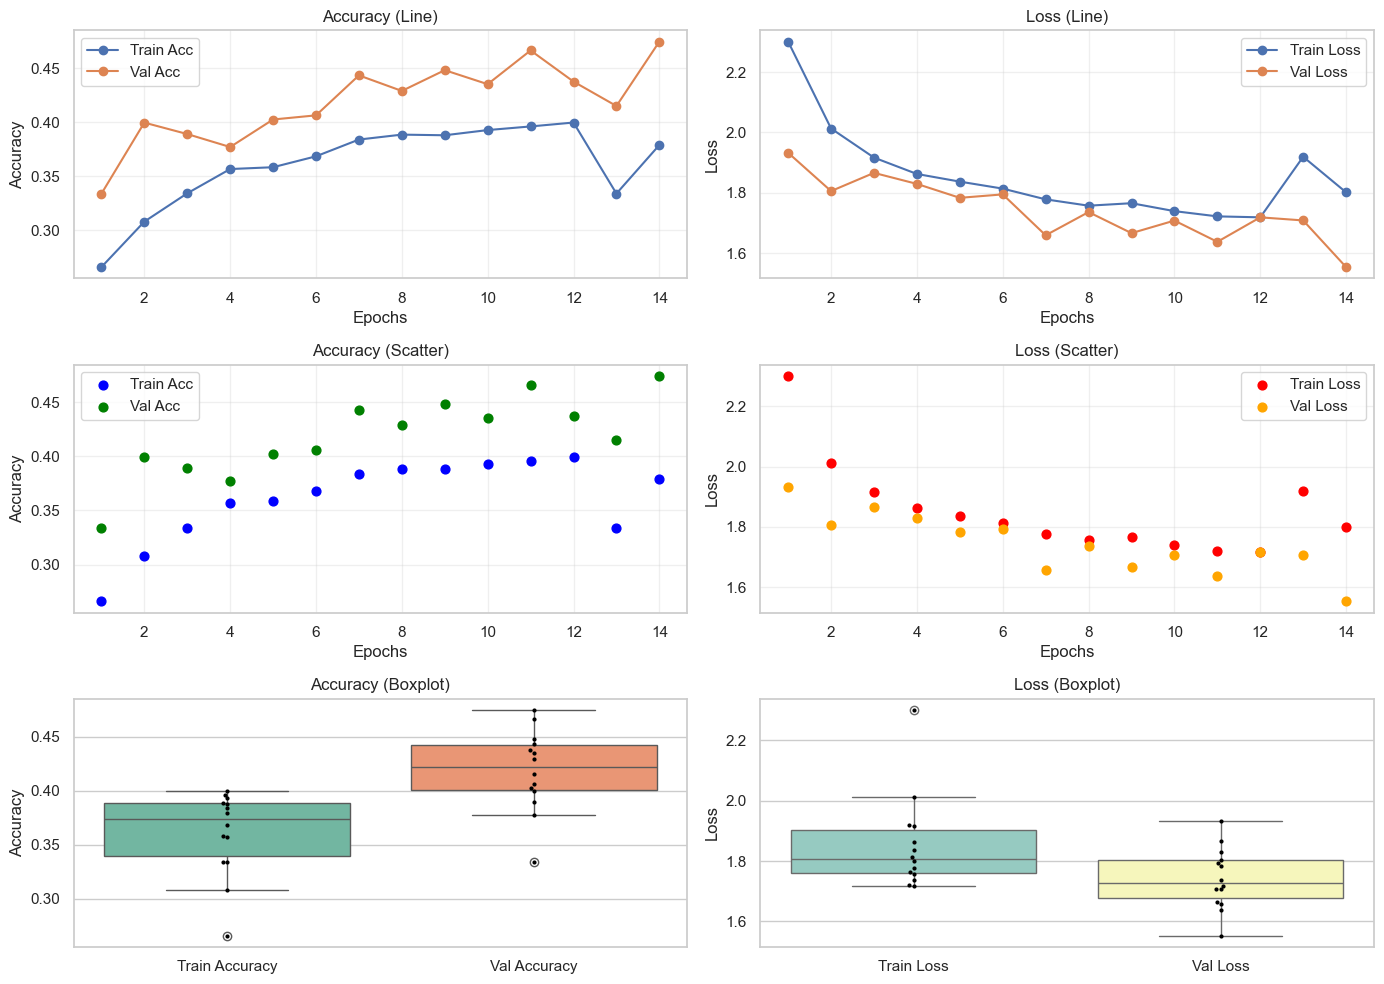

In [91]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# DataFrame for boxplots
history_df = pd.DataFrame({
    "Train Accuracy": acc,
    "Val Accuracy": val_acc,
    "Train Loss": loss,
    "Val Loss": val_loss
})

plt.figure(figsize=(14, 10))   # small + compact frame

# ----------------- 1. Line Plot: Accuracy -----------------
plt.subplot(3, 2, 1)
plt.plot(epochs, acc, '-o', label='Train Acc')
plt.plot(epochs, val_acc, '-o', label='Val Acc')
plt.title("Accuracy (Line)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

# ----------------- 2. Line Plot: Loss -----------------
plt.subplot(3, 2, 2)
plt.plot(epochs, loss, '-o', label='Train Loss')
plt.plot(epochs, val_loss, '-o', label='Val Loss')
plt.title("Loss (Line)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# ----------------- 3. Scatter Plot: Accuracy -----------------
plt.subplot(3, 2, 3)
plt.scatter(epochs, acc, color='blue', s=40, label="Train Acc")
plt.scatter(epochs, val_acc, color='green', s=40, label="Val Acc")
plt.title("Accuracy (Scatter)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

# ----------------- 4. Scatter Plot: Loss -----------------
plt.subplot(3, 2, 4)
plt.scatter(epochs, loss, color='red', s=40, label="Train Loss")
plt.scatter(epochs, val_loss, color='orange', s=40, label="Val Loss")
plt.title("Loss (Scatter)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# ----------------- 5. Boxplot: Accuracy -----------------
plt.subplot(3, 2, 5)
sns.boxplot(data=history_df[["Train Accuracy", "Val Accuracy"]], palette="Set2")
sns.swarmplot(data=history_df[["Train Accuracy", "Val Accuracy"]], color="black", size=3)
plt.title("Accuracy (Boxplot)")
plt.ylabel("Accuracy")

# ----------------- 6. Boxplot: Loss -----------------
plt.subplot(3, 2, 6)
sns.boxplot(data=history_df[["Train Loss", "Val Loss"]], palette="Set3")
sns.swarmplot(data=history_df[["Train Loss", "Val Loss"]], color="black", size=3)
plt.title("Loss (Boxplot)")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


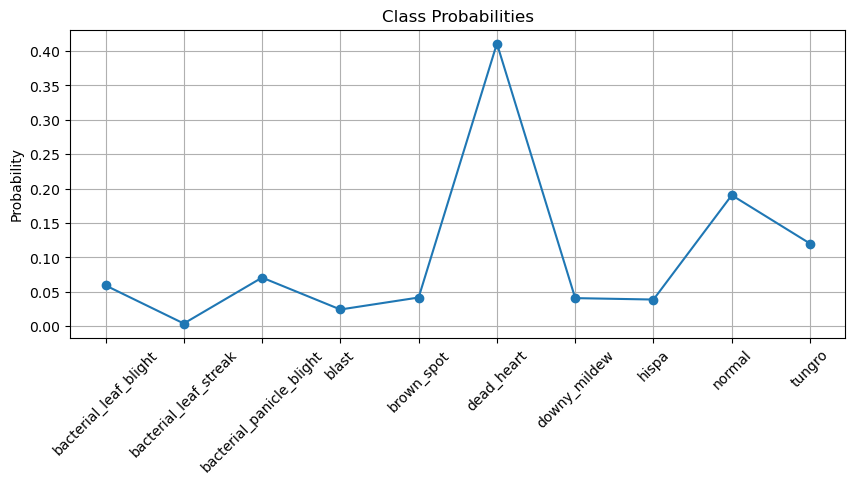

In [73]:
def plot_class_probabilities(image_path):
    img_arr = preprocess_for_model(image_path)
    preds = model.predict(np.expand_dims(img_arr,0))[0]

    classes = list(labels_map.values())
    plt.figure(figsize=(10,4))
    plt.plot(classes, preds, marker='o')
    plt.xticks(rotation=45)
    plt.title("Class Probabilities")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

# Example use
plot_class_probabilities(r"C:\Users\prath\OneDrive\Desktop\train_images\tungro\100287.jpg")


In [86]:
# Grad-CAM helper and create overlays for few samples (pre
import tensorflow as tf
def find_last_conv_layer(model):
    last=None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last = layer.name; break
    return last or "conv5_block3_out"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap); heatmap = tf.maximum(heatmap,0) / (tf.math.reduce_max(heatmap)+1e-8)
    return heatmap.numpy()

def overlay_and_save(orig_path, heatmap, out_path, alpha=0.4):
    img = cv2.imread(str(orig_path))
    hm = cv2.resize(heatmap, (img.shape[1], img.shape[0])); hm = np.uint8(255*hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    overlay = (hm*alpha + img).astype('uint8')
    cv2.imwrite(str(out_path), overlay)

if all(v in globals() for v in ['model','val_df','y_true','y_pred']):
    last_conv = find_last_conv_layer(model)
    OUT_CAM = OUTDIR/"gradcam_examples"; OUT_CAM.mkdir(exist_ok=True)
    # show 3 correct and 3 misclassified
    correct_idxs = np.where(y_true==y_pred)[0]
    mis_idxs = np.where(y_true!=y_pred)[0]
    sample_correct = np.random.choice(correct_idxs, min(3,len(correct_idxs)), replace=False) if len(correct_idxs)>0 else []
    sample_mis = np.random.choice(mis_idxs, min(6,len(mis_idxs)), replace=False) if len(mis_idxs)>0 else []
    def process_indices(idxs, tag):
        for i_idx in idxs:
            try:
                img_path = val_generator.filepaths[i_idx]
                arr = np.array(Image.open(img_path).convert('RGB').resize(IMG_SIZE)).astype(np.float32)/255.0
                hm = make_gradcam_heatmap(np.expand_dims(arr,0), model, last_conv, pred_index=None)
                outp = OUT_CAM/f"{tag}_{Path(img_path).stem}.jpg"
                overlay_and_save(img_path, hm, outp)
            except Exception as e:
                print("Grad-CAM error:", e)
    process_indices(sample_correct, "correct")
    process_indices(sample_mis, "mis")
    print("Saved Grad-CAM examples to", OUT_CAM)
else:
    print("Missing model/val_df/y_true/y_pred — skip Grad-CAM.")


Grad-CAM error: No such layer: conv5_block3_out. Existing layers are: ['input_layer_4', 'resnet50', 'gap', 'batch_normalization', 'dropout', 'dense', 'batch_normalization_1', 'dropout_1', 'dense_1'].
Grad-CAM error: No such layer: conv5_block3_out. Existing layers are: ['input_layer_4', 'resnet50', 'gap', 'batch_normalization', 'dropout', 'dense', 'batch_normalization_1', 'dropout_1', 'dense_1'].
Grad-CAM error: No such layer: conv5_block3_out. Existing layers are: ['input_layer_4', 'resnet50', 'gap', 'batch_normalization', 'dropout', 'dense', 'batch_normalization_1', 'dropout_1', 'dense_1'].
Grad-CAM error: No such layer: conv5_block3_out. Existing layers are: ['input_layer_4', 'resnet50', 'gap', 'batch_normalization', 'dropout', 'dense', 'batch_normalization_1', 'dropout_1', 'dense_1'].
Grad-CAM error: No such layer: conv5_block3_out. Existing layers are: ['input_layer_4', 'resnet50', 'gap', 'batch_normalization', 'dropout', 'dense', 'batch_normalization_1', 'dropout_1', 'dense_1'].


In [87]:
# Batch predict folder or val_generator -> produce CSV with top1 & confidence
if model is not None:
    preds_info=[]
    if 'val_generator' in globals():
        val_generator.reset()
        probs = model.predict(val_generator, verbose=1)
        pred_idx = probs.argmax(axis=1)
        for i, p in enumerate(pred_idx):
            filepath = val_generator.filepaths[i]
            pred_label = labels_map[int(p)]
            confidence = float(probs[i,int(p)])*100.0
            true_label = val_generator.classes[i] if hasattr(val_generator,'classes') else None
            preds_info.append({"filepath":filepath, "pred_label":pred_label, "confidence_pct":confidence, "true": labels_map[true_label] if true_label is not None else None})
    else:
        # fallback: predict small set from df
        for p in df['filepath'].sample(min(100,len(df)), random_state=1):
            arr = np.array(Image.open(p).convert('RGB').resize(IMG_SIZE)).astype(np.float32)/255.0
            prob = model.predict(np.expand_dims(arr,0))[0]
            pi = int(np.argmax(prob)); preds_info.append({"filepath":p, "pred_label":labels_map[pi], "confidence_pct":float(prob[pi])*100.0})
    import pandas as pd
    pd.DataFrame(preds_info).to_csv(OUTDIR/"batch_predictions.csv", index=False)
    print("Saved batch_predictions.csv")
else:
    print("Model not loaded - skip batch prediction.")


131/131 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step
Saved batch_predictions.csv


In [88]:
# Summary: list saved files
print("Saved visualization files in:", OUTDIR)
for f in sorted(OUTDIR.glob("*.png")):
    print("-", f.name)
if (OUTDIR/"class_counts.csv").exists(): print("- class_counts.csv")
if (OUTDIR/"batch_predictions.csv").exists(): print("- batch_predictions.csv")


Saved visualization files in: viz_outputs
- aspect_area.png
- aug_preview.png
- bar_counts.png
- brightness.png
- confusion_matrix.png
- donut_counts.png
- image_sizes.png
- one_sample_per_class.png
- per_class_accuracy.png
- pie_counts.png
- rgb_means.png
- roc_curves.png
- train_val_counts.png
- class_counts.csv
- batch_predictions.csv


In [60]:
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import json

# ======= SET YOUR MODEL FILE ==========
MODEL_PATH = "paddy_resnet50_model.keras"  # or .h5
# ======================================

# Load model
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Load class labels from generator or json
try:
    class_indices = train_generator.class_indices
except:
    try:
        class_indices = val_generator.class_indices
    except:
        try:
            with open("class_indices.json", "r") as f:
                class_indices = json.load(f)
        except:
            raise ValueError("Could not find class_indices!")

# Convert dict {class:idx} to {idx:class}
labels_map = {v: k for k, v in class_indices.items()}

print("Model loaded successfully!")
print("Classes:", labels_map)


Model loaded successfully!
Classes: {0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}


In [61]:
# Improved predict & show (top-3, suppress warnings, clear output types)
import tensorflow as tf, numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

# --- config ---
IMG_SIZE = (224, 224)
CONFIDENCE_THRESHOLD = 50.0   # percent; mark as "UNCERTAIN" if top < this
SUPPRESS_TF_WARNINGS = True

if SUPPRESS_TF_WARNINGS:
    # Hide TF INFO/DEBUG log spam
    tf.get_logger().setLevel('ERROR')
    warnings.filterwarnings("ignore")  # hide other warnings (optional)

def predict_and_show_topk(image_path, model, labels_map, img_size=IMG_SIZE, top_k=3):
    image_path = Path(image_path)
    if not image_path.exists():
        raise ValueError(f"Image not found: {image_path}")

    # Load & show original image
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Input: {image_path.name}")
    plt.show()

    # Preprocess into consistent numpy float32 shape to avoid retracing
    img_resized = img.resize(img_size)
    img_arr = np.array(img_resized).astype(np.float32) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)  # shape (1, H, W, 3)

    # Predict
    preds = model.predict(img_arr)  # shape (1, num_classes)
    probs = preds[0].astype(np.float32)  # convert to native float32

    # Top-k indices & labels
    topk_idx = probs.argsort()[-top_k:][::-1]
    topk = [(int(i), labels_map[int(i)], float(probs[int(i)])*100.0) for i in topk_idx]

    # Display results
    print("="*50)
    print("Top-{} predictions:".format(top_k))
    for rank, (idx, label, pct) in enumerate(topk, start=1):
        uncertain_tag = "  <-- UNCERTAIN" if (rank == 1 and pct < CONFIDENCE_THRESHOLD) else ""
        print(f"{rank}. {label:20s} : {pct:6.2f}%{uncertain_tag}")
    print("="*50)

    # Return structured result
    result = {
        "filepath": str(image_path),
        "topk": [{"index": idx, "label": label, "confidence_pct": pct} for idx, label, pct in [(i,l,p) for (i,l,p) in [(t[0],t[1],t[2]) for t in topk]]]
    }
    return result

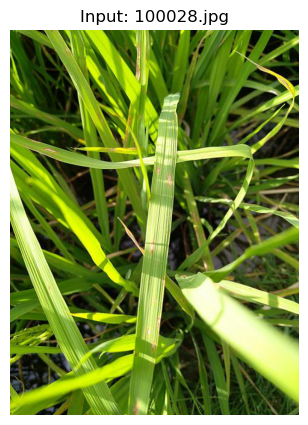

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top-1 predictions:
1. brown_spot           :  69.28%

Returned Result:
{'filepath': 'C:\\Users\\prath\\OneDrive\\Desktop\\train_images\\brown_spot\\100028.jpg', 'topk': [{'index': 4, 'label': 'brown_spot', 'confidence_pct': 69.27891373634338}]}


In [62]:
# ==== EXAMPLE USAGE ====

image_path = r"C:\Users\prath\OneDrive\Desktop\train_images\brown_spot\100028.jpg"   # <- change to your image

result = predict_and_show_topk(
    image_path=image_path,
    model=model,
    labels_map=labels_map,
    top_k=1   # top 3 predictions
)

print("\nReturned Result:")
print(result)
